# CNN - CIFAR10 - Data Augmentation

• Sebastian Häni haeniseb@students.zhaw.ch

• Raffael Affolter affolraf@students.zhaw.ch

• Benjamin Mäder maedeben@students.zhaw.ch

In [1]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [34]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

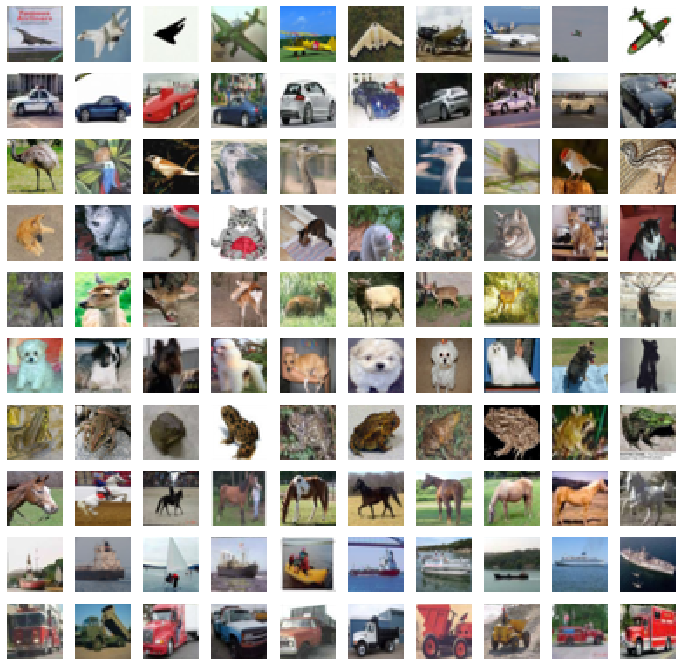

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [3]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [5]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [6]:
X_train[1].shape

(32, 32, 3)

In [7]:
cnn = Sequential()
#CONV(32F,same)-RELU-CONV(32F,same)-RELU
cnn.add(Conv2D(32, (3, 3), padding='same',strides = (1,1), input_shape= (32,32,3),activation = "relu"))
cnn.add(Conv2D(32, (3, 3), padding='same',strides = (1,1), input_shape= (32,32,32),activation = "relu"))

#MAXP(2)
cnn.add(MaxPooling2D(pool_size=(2, 2)))

#CONV(32F,same)
cnn.add(Conv2D(32, (3, 3), padding='same',strides = (1,1), input_shape= (16,16,32),activation = "relu"))

#MAXP(2)
cnn.add(MaxPooling2D(pool_size=(2, 2)))


cnn.add(Flatten())
cnn.add(Dense(10 , activation = "softmax"))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                2

In [8]:
Batch = 128
Epochs = 10

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [9]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
log = cnn.fit(X_train,
              Y_train,
              batch_size=Batch,
              epochs=Epochs,
              verbose=1,
              validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 73s 1ms/sample - loss: 1.5972 - accuracy: 0.4322 - val_loss: 1.3150 - val_accuracy: 0.5315
Epoch 2/10
50000/50000 [==============================] - 72s 1ms/sample - loss: 1.2014 - accuracy: 0.5794 - val_loss: 1.0888 - val_accuracy: 0.6232
Epoch 3/10
50000/50000 [==============================] - 71s 1ms/sample - loss: 1.0280 - accuracy: 0.6427 - val_loss: 1.0316 - val_accuracy: 0.6394
Epoch 4/10
50000/50000 [==============================] - 72s 1ms/sample - loss: 0.9411 - accuracy: 0.6741 - val_loss: 0.9542 - val_accuracy: 0.6690
Epoch 5/10
50000/50000 [==============================] - 72s 1ms/sample - loss: 0.8716 - accuracy: 0.6973 - val_loss: 0.9618 - val_accuracy: 0.6701
Epoch 6/10
50000/50000 [==============================] - 73s 1ms/sample - loss: 0.8201 - accuracy: 0.7173 - val_loss: 0.8817 - val_accuracy: 0.6967
Epoch 7/10
50000/50000 [==============================] 

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

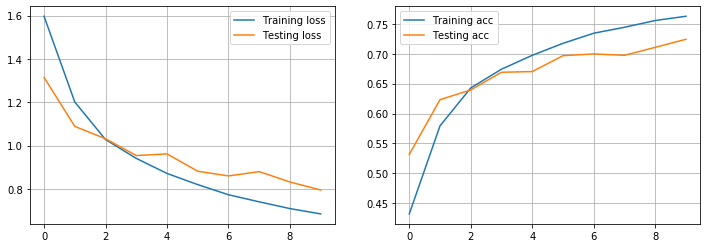

In [10]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [11]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.7949832747459412
Test accuracy: 0.7241


### Confusion matrix
We can call the `predict_classes()` function to get the predicted classes. The output of this function is an array with the predicted class labels as in `[5 0 4 1 ...]`. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [12]:
pred = cnn.predict_classes(X_test, verbose=0)
confusion_matrix(y_test, pred)

array([[745,  18,  62,  21,  16,   3,  10,   8,  70,  47],
       [ 21, 835,   5,   2,   3,   3,   8,   4,  14, 105],
       [ 56,   6, 605,  64,  85,  56,  55,  46,  10,  17],
       [ 23,  14,  80, 518,  71, 173,  59,  29,  11,  22],
       [ 27,   2,  85,  66, 664,  35,  54,  54,   9,   4],
       [ 17,   0,  51, 164,  36, 654,  16,  43,  10,   9],
       [  7,   5,  47,  62,  34,  20, 810,   5,   4,   6],
       [ 18,   4,  41,  38,  45,  61,   5, 771,   6,  11],
       [ 66,  39,  13,  10,   8,   6,   9,   7, 800,  42],
       [ 30,  60,   6,  14,  10,   5,   6,  13,  17, 839]])

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation pipelines, one for train set, one for test set
gen = ImageDataGenerator(rotation_range=8,
                         width_shift_range=0.1,
                         shear_range=0.2,
                         height_shift_range=0.1,
                         zoom_range=0.15)
batches = gen.flow(X_train, Y_train, batch_size=256)
val_batches = gen.flow(X_test, Y_test, batch_size=256)

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above. 

In [51]:
# Compile and train the network
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
log = cnn.fit_generator(batches,
                        steps_per_epoch=60000 // 256,
                        epochs=10,
                        validation_data=val_batches,
                        validation_steps=10000 // 256,
                        use_multiprocessing=True)

Epoch 1/10
234/234 [==============================] - 109s 467ms/step - loss: 0.7873 - accuracy: 0.7287 - val_loss: 0.8512 - val_accuracy: 0.7069
Epoch 2/10
234/234 [==============================] - 112s 478ms/step - loss: 0.7777 - accuracy: 0.7315 - val_loss: 0.8772 - val_accuracy: 0.6988
Epoch 3/10
234/234 [==============================] - 108s 463ms/step - loss: 0.7757 - accuracy: 0.7298 - val_loss: 0.8289 - val_accuracy: 0.7160
Epoch 4/10
234/234 [==============================] - 106s 453ms/step - loss: 0.7679 - accuracy: 0.7326 - val_loss: 0.8361 - val_accuracy: 0.7120
Epoch 5/10
234/234 [==============================] - 107s 458ms/step - loss: 0.7612 - accuracy: 0.7361 - val_loss: 0.8169 - val_accuracy: 0.7171
Epoch 6/10
234/234 [==============================] - 106s 453ms/step - loss: 0.7597 - accuracy: 0.7368 - val_loss: 0.8160 - val_accuracy: 0.7184
Epoch 7/10
234/234 [==============================] - 106s 451ms/step - loss: 0.7535 - accuracy: 0.7397 - val_loss: 0.8001 -

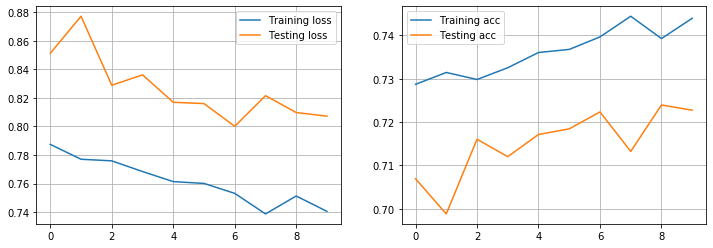

In [52]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [53]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8349340975761413
Test accuracy: 0.7296


### Table of results

Describe your data augmentation strategies here.

| CNN | Architecture description | Acc. train | Acc. test |
|-----|--------------------------|------------|-----------|
|  No DA | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.7626 | 0.7241 |
|  With DA v1 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | ...  | 0.6792 |
|  With DA v2 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.744  | 0.7296 |
| ... | | | |

## Visualisation of Activations


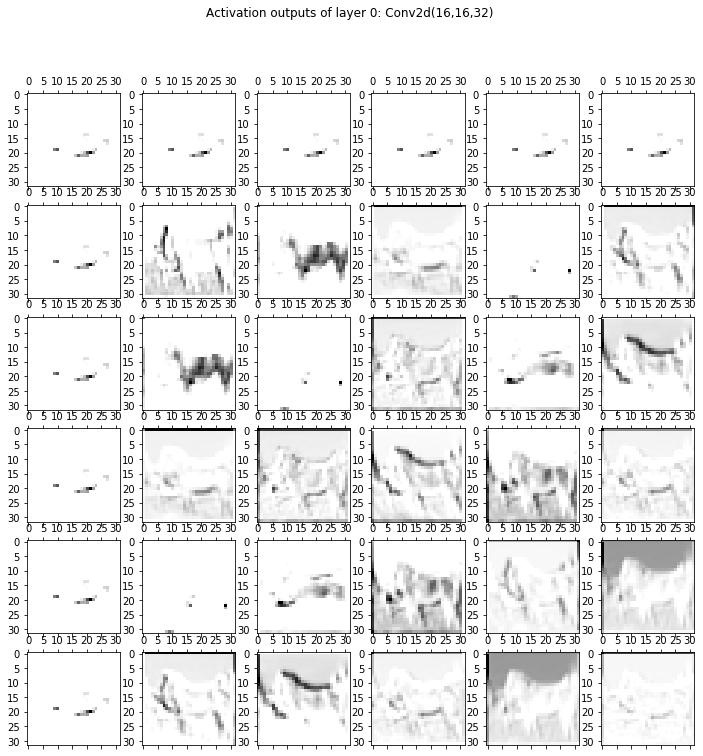

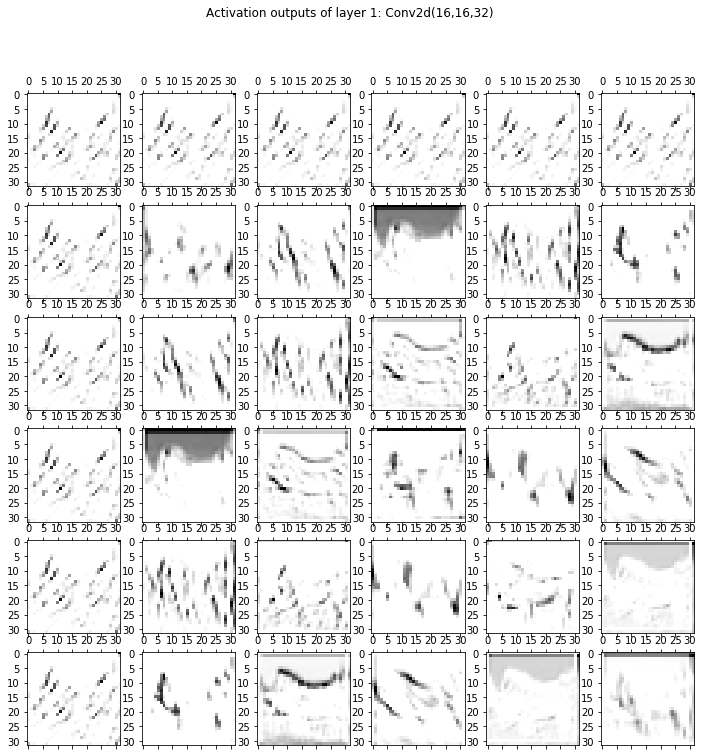

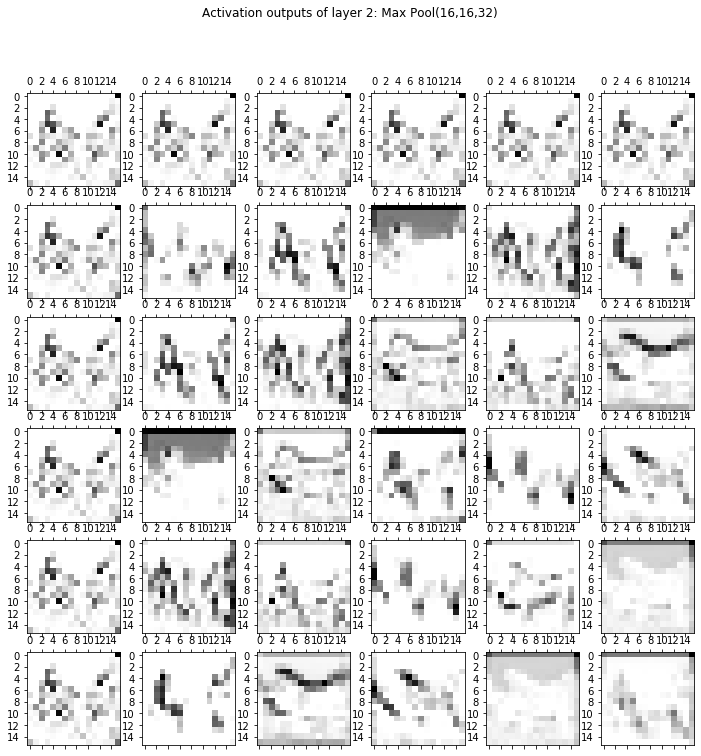

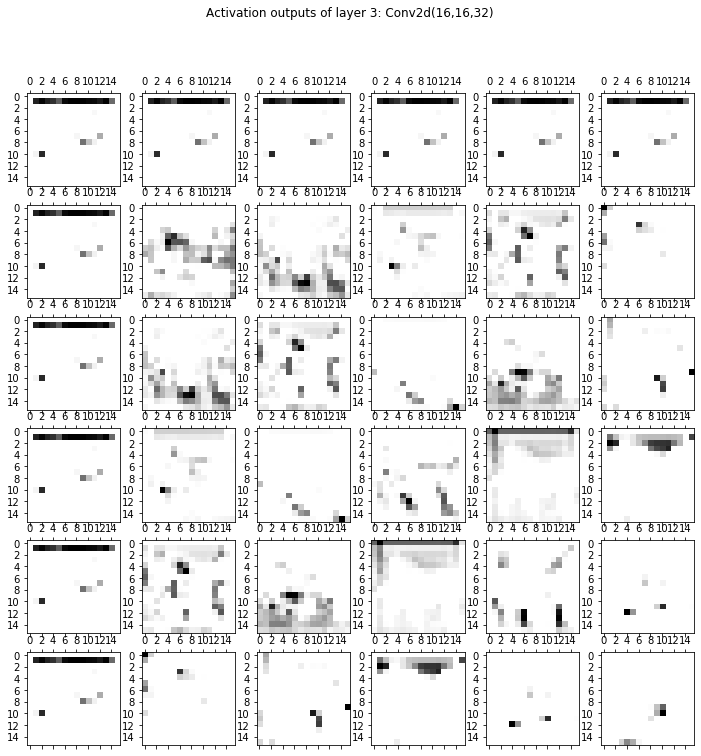

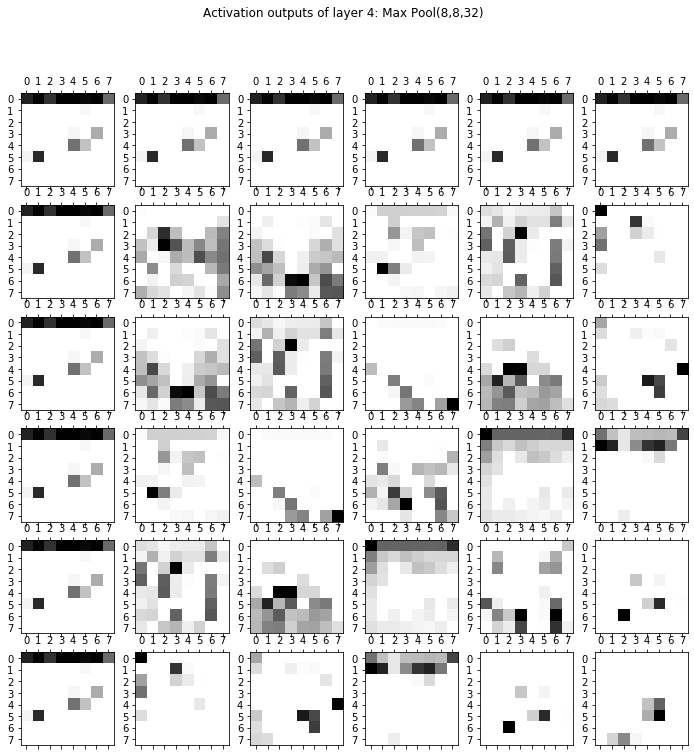

In [54]:
def plot_activations(model, im, l, title=''):
    fig, axs = plt.subplots(6, 6, figsize=(12,12))
    fig.suptitle('Activation outputs of layer ' + str(l) + ': ' + title)

    # extracts the output of the layer
    layer_output = cnn.layers[l].output
    # creates a model able to return these outputs, given an input
    activation_model = models.Model(inputs=cnn.input, outputs=layer_output)
    # we need to reshape the image (32, 32, 3) into (1, 32, 32, 3)
    # as the network expect a batch of images as input
    im = im.reshape(1, 32, 32, 3)
    # returns the layer activation
    activation = activation_model.predict(im)
    # display the activations of the layer
    for i in range(0, 6):
        for j in range(0, 6):
            axs[i, j].matshow(activation[0, :, :, i * j], cmap='Greys')

img_idx = 12
plot_activations(cnn, X_train[img_idx], 0, 'Conv2d(16,16,32)')
plot_activations(cnn, X_train[img_idx], 1, 'Conv2d(16,16,32)')
plot_activations(cnn, X_train[img_idx], 2, 'Max Pool(16,16,32)')
plot_activations(cnn, X_train[img_idx], 3, 'Conv2d(16,16,32)')
plot_activations(cnn, X_train[img_idx], 4, 'Max Pool(8,8,32)')

### Comments

* In the first two activation visualizations we see the result of simple convolutions, as we would expect given I have some familiarity with convolutions from a classical computer vision course.
* The max pool layer is aggregating the two results into a smaller weights vector.
* The next Conv and Max Pool layer repeat the process and we get some abstract results that no human could decipher anymore.